In [1]:
# Import data

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might b

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

# 載入資料
train_image_data = torch.load("../SML_train_dataset.pt")
graph_data = torch.load("../train_graph_dataset.pt")

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_30582/2116005886.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_image_data = torch.load("../SML_train_d

In [9]:
import torch
from torch.utils.data import Dataset

class importDataset(Dataset):
    def __init__(self, S_tiles, M_tiles, L_tiles, labels, meta_info, normal_coords, node_feats, adj_lists,edge_feats):
        """
        Custom Dataset to load image tiles, labels, and edge indices for training.
        
        Args:
            S_tiles (list): Small scale image tiles (spot-level features).
            M_tiles (list): Medium scale image tiles (spot-level features).
            L_tiles (list): Large scale image tiles (spot-level features).
            labels (list): Ground truth labels (spot-level cell type compositions).
            meta_info (list): Metadata containing slide_id, x, y coordinates for each spot.
            normal_coords (list): Normalized coordinates for each spot.
            slide_edge_indices (dict): Dictionary containing the slide-level edge indices for each slide.
        """
        self.S_tiles = S_tiles
        self.M_tiles = M_tiles
        self.L_tiles = L_tiles
        self.labels = labels
        self.meta_info = meta_info
        self.normal_coords = normal_coords
        self.node_feats = node_feats
        self.adj_lists = adj_lists
        self.edge_feats = edge_feats
        # Optional: Apply any additional processing to the data here
        # e.g., scaling, normalization, etc.

    def __len__(self):
        # Return the number of samples (spots) in the dataset
        return len(self.S_tiles)

    def __getitem__(self, idx):
        # Get the spot-level data for the sample at index `idx`
        S_tile = self.S_tiles[idx]
        M_tile = self.M_tiles[idx]
        L_tile = self.L_tiles[idx]
        label = self.labels[idx]
        meta = self.meta_info[idx]  # This is a tuple (slide_id, x, y)
        normal_coord = self.normal_coords[idx]
        adj_list = self.adj_lists[idx]
        
        # Convert the tiles to the correct format (channels-first)
        S_tile = torch.tensor(S_tile, dtype=torch.float).permute(2, 0, 1)  # Convert from (H, W, 3) to (3, H, W)
        M_tile = torch.tensor(M_tile, dtype=torch.float).permute(2, 0, 1)
        L_tile = torch.tensor(L_tile, dtype=torch.float).permute(2, 0, 1)
        
        # Convert label and normal_coord to tensors
        label = torch.tensor(label, dtype=torch.float)
        normal_coord = torch.tensor(normal_coord, dtype=torch.float)
        # ➕ Graph features
        max_neighbors = 7  # or whatever k you use
        adj_list = self.adj_lists[idx] if self.adj_lists is not None else []

        # 轉成固定長度的 Tensor
        adj_array = np.zeros((max_neighbors, 2))
        for i, (j, w) in enumerate(adj_list[:max_neighbors]):
            adj_array[i] = [j, w]
         # 🛠️ edge_feat 轉型處理
        edge_feat_i = self.edge_feats[idx]
        if isinstance(edge_feat_i, np.ndarray) and edge_feat_i.dtype == object:
            edge_feat_i = np.array(edge_feat_i.tolist())
        elif isinstance(edge_feat_i, list):
            edge_feat_i = np.array(edge_feat_i)


        graph_feats = {
            'node_feat': torch.tensor(self.node_feats[idx], dtype=torch.float) if self.node_feats is not None else None,
            'adj_list': torch.tensor(adj_array, dtype=torch.float),
            'edge_feat': torch.tensor(edge_feat_i, dtype=torch.float) if edge_feat_i is not None else None,
        }
        # Return the data in a PyTorch-friendly format as a dictionary
        return {
            'S_tile': S_tile,
            'M_tile': M_tile,
            'L_tile': L_tile,
            'label': label,
            'meta': meta,
            'normal_coord': normal_coord,
            **graph_feats  # ➕ 合併進 batch dictionary
        }


In [10]:
# ====== Step 2: 建立 Dataset ======
image_train_dataset = importDataset(
    S_tiles=train_image_data['S_tiles'],
    M_tiles=train_image_data['M_tiles'],
    L_tiles=train_image_data['L_tiles'],
    labels=train_image_data['labels'],
    meta_info=train_image_data['meta_info'],
    normal_coords=train_image_data['normal_coords'],
    node_feats=graph_data['node_feats'],
    adj_lists=graph_data['adj_lists'],
    edge_feats=graph_data['edge_feats']
)


In [14]:
def check_dataset_item(dataset, idx=0):
    item = dataset[idx]

    print("🔍 Checking dataset sample:", idx)

    # --- Center Tile ---
    tile = item['S_tile']
    print(f"📏 Center tile shape: {tile.shape} | dtype: {tile.dtype} | min: {tile.min():.3f}, max: {tile.max():.3f}")

    # --- Subtiles ---
    subtiles = item['M_tile']
    print(f"📏 Subtiles shape: {subtiles.shape} | dtype: {subtiles.dtype}")

    # --- Neighbors ---
    neighbors = item['L_tile']
    print(f"📏 Neighbor tiles shape: {neighbors.shape} | dtype: {neighbors.dtype}")

    # --- Label ---
    label = item['label']
    print(f"🧬 Label shape: {label.shape} | dtype: {label.dtype}")
    assert label.shape[0] == 35 and label.dtype == torch.float32, "❌ Label 應為 float32 且長度為 35"

    # --- Coordinates (meta) ---
    coordinates = item['meta']
    print(f"📌 Coordinates (meta): x = {coordinates[1]}, y = {coordinates[2]}")

    # --- Node Features ---
    if 'node_feat' in item and item['node_feat'] is not None:
        node_feat = item['node_feat']
        print(f"📊 Node feature shape: {node_feat.shape} | dtype: {node_feat.dtype}")


    # --- Edge Features ---
    if 'edge_feat' in item and item['edge_feat'] is not None:
        edge_feat = item['edge_feat']
        print(f"🔗 Edge feature shape: {edge_feat.shape} | dtype: {edge_feat.dtype}")
        print(f"🔗 Sample edge_feat[0]: {edge_feat[0]}")
        assert edge_feat.ndim == 2 and edge_feat.shape[1] == 5, "❌ Edge feature 應為 (k, 5)"
    else:
        print("⚠️ Edge features 未提供")

    # --- Adjacency List ---
    if 'adj_list' in item and item['adj_list'] is not None:
        adj_list = item['adj_list']
        print(f"📎 Adjacency list shape: {adj_list.shape} | dtype: {adj_list.dtype}")
        print(f"📎 Sample: {adj_list[:3]}")
        assert adj_list.ndim == 2 and adj_list.shape[1] == 2, "❌ Adjacency list 應為 (k, 2)"
    else:
        print("⚠️ Adjacency list 未提供")

    print("✅ All checks passed!")




    
check_dataset_item(image_train_dataset)


🔍 Checking dataset sample: 0
📏 Center tile shape: torch.Size([3, 32, 32]) | dtype: torch.float32 | min: 0.451, max: 1.000
📏 Subtiles shape: torch.Size([3, 64, 64]) | dtype: torch.float32
📏 Neighbor tiles shape: torch.Size([3, 128, 128]) | dtype: torch.float32
🧬 Label shape: torch.Size([35]) | dtype: torch.float32
📌 Coordinates (meta): x = 1554, y = 1297
📊 Node feature shape: torch.Size([14]) | dtype: torch.float32
🔗 Edge feature shape: torch.Size([7, 5]) | dtype: torch.float32
🔗 Sample edge_feat[0]: tensor([26.0000, 26.0000,  0.0000,  0.0000,  0.0385])
📎 Adjacency list shape: torch.Size([7, 2]) | dtype: torch.float32
📎 Sample: tensor([[6.2800e+02, 3.8462e-02],
        [2.3700e+02, 3.8462e-02],
        [1.3880e+03, 3.7851e-02]])
✅ All checks passed!


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_30582/3814644018.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'node_feat': torch.tensor(self.node_feats[idx], dtype=torch.float) if self.node_feats is not None else None,


In [ ]:
import torch
from torch.utils.data import Subset
import numpy as np


# 確定數據集的總大小（兩者必須相同）
dataset_size = len(image_train_dataset)  # 同時 image_train_dataset 和 graph_train_dataset 長度應相同

# 設定訓練比例，這裡以 80% 為訓練集，20% 為驗證集
train_ratio = 0.8
split_index = int(np.floor(train_ratio * dataset_size))

# 生成隨機索引
indices = torch.randperm(dataset_size).tolist()

# 將索引拆分為訓練和驗證部分
train_indices = indices[:split_index]
val_indices = indices[split_index:]

# 使用 Subset 根據相同的索引建立子集
image_train_subset = Subset(image_train_dataset, train_indices)
image_val_subset = Subset(image_train_dataset, val_indices)

# 現在，你有兩對 DataLoader，且它們的索引是一一對應的
print(f"✅ Train set size: {len(image_train_subset)} samples")
print(f"✅ Validation set size: {len(image_val_subset)} samples")

✅ Train set size: 6679 samples
✅ Validation set size: 1670 samples


In [56]:
from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch



train_loader = DataLoader(image_train_subset, batch_size=32, shuffle=True)

val_loader = DataLoader(image_val_subset, batch_size=32, shuffle=True)


# 測試一下 DataLoader 取出的數據
for batch in train_loader:

    print("Image sample keys:", batch.keys() if hasattr(batch, 'keys') else "Not a dict")
    break

Image sample keys: dict_keys(['S_tile', 'M_tile', 'L_tile', 'label', 'meta', 'normal_coord', 'node_feat', 'adj_list', 'edge_feat'])


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_30582/3814644018.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'node_feat': torch.tensor(self.node_feats[idx], dtype=torch.float) if self.node_feats is not None else None,


Poteintial issues:
# 1. my val_set tiles image may be included in the sub_tiles of train_set

Note: Since neighbor tiles are reused across samples, some mild information overlap may exist between train and val sets. However, final test set is completely held out.

# Neural Network

import torch
import torch.nn as nn
from torch_geometric.nn import GraphSAGE, global_mean_pool
from torch_geometric.data import Data



# --- CustomGAT 定義 ---
class CustomGAT(nn.Module):
    def __init__(self, in_features, n_heads=8, head_dim=32):
        """
        in_features: 每個節點初始特徵維度（這裡應為 14）
        n_heads: 注意力頭數（例如 8）
        head_dim: 每個注意力頭輸出維度（例如 32）
        """
        super(CustomGAT, self).__init__()
        self.n_heads = n_heads
        self.head_dim = head_dim
        # 對每個注意力頭都有一個線性變換矩陣，輸出 shape: [B, head_dim]
        self.W = nn.Parameter(torch.randn(n_heads, in_features, head_dim))
        # 注意力計算參數，分別對 query 和 key 作用
        self.a1 = nn.Parameter(torch.randn(n_heads, head_dim, 1))
        self.a2 = nn.Parameter(torch.randn(n_heads, head_dim, 1))
        self.leakyrelu = nn.LeakyReLU(0.01)
    
    def forward(self, node_features, adj_list, edge_feat):
        """
        node_features: tensor, shape [B, in_features] ；B = batch size（代表 B 個 spots）
        adj_list: tensor, shape [B, num_neighbors, 2]
                  假設每個元素的第一個值是鄰居索引（可能為 float），第二個值為權重（可忽略）
        edge_feat: tensor, shape [B, num_neighbors, edge_feat_dim]；例如 edge_feat_dim = 5
        """
        B = node_features.size(0)
        num_neighbors = adj_list.size(1)
        head_outputs = []
        
        for h in range(self.n_heads):
            # 線性變換：對每個節點做變換
            # transformed: [B, head_dim]
            transformed = torch.matmul(node_features, self.W[h])
            # 初始化注意力得分矩陣 e，形狀 [B, B]，但我們只對每個 node i 與其鄰居 j 進行計算
            # 這裡我們用 -inf 填充非鄰居位置
            e = torch.full((B, B), float('-inf'), device=node_features.device)
            
            # 對每個節點 i
            for i in range(B):
                # 取出該 node 的鄰居資訊，形狀 [num_neighbors, 2]
                # 我們需要獲得鄰居索引，並確保為整數
                neighbors = adj_list[i, :, 0]  # shape: [num_neighbors]
                # 如果 neighbors 是浮點型，將其轉換為 int
                neighbors = neighbors.long()  # 如果原始存的是 float，可直接用 .long()
                for k in range(num_neighbors):
                    j = int(neighbors[k].item())  # j 為鄰居索引
                    # 取得變換後的特徵：query 與 key 分別 [head_dim, 1]
                    query = transformed[i].unsqueeze(1)
                    key   = transformed[j].unsqueeze(1)
                    e_ij = torch.matmul(self.a1[h].T, query) + torch.matmul(self.a2[h].T, key)
                    e_ij = self.leakyrelu(e_ij)
                    # 如果提供了 edge_feat，根據邊特徵調整 e_ij
                    if edge_feat is not None:
                        # 取出對應邊的特徵，形狀: [edge_feat_dim]
                        current_edge_feat = edge_feat[i, k]  # tensor, shape: [edge_feat_dim]
                        # 這裡簡單使用第一個值作為調整因子
                        e_ij *= 1.0 / (current_edge_feat[0] + 1e-6)
                    # 將計算好的 e_ij 存入對應的位置 [i, j]
                    e[i, j] = e_ij.squeeze()
            
            # 對每個節點的鄰居注意力得分進行 softmax
            attention = F.softmax(e, dim=1)  # [B, B]
            # 聚合鄰居的訊息：對每個節點 i，用鄰居 j 的變換後特徵加權求和
            head_output = torch.zeros(B, self.head_dim, device=node_features.device)
            for i in range(B):
                weighted_sum = torch.zeros(self.head_dim, device=node_features.device)
                for j in range(B):
                    if attention[i, j] > 0:
                        weighted_sum += attention[i, j] * transformed[j]
                head_output[i] = F.relu(weighted_sum)
            head_outputs.append(head_output)
        
        # 多頭拼接：最終輸出 shape [B, n_heads*head_dim]
        multi_head_output = torch.cat(head_outputs, dim=1)
        return multi_head_output
# Define a CNN for each scale (S_tile, M_tile, L_tile)
class SmallScaleCNN(nn.Module):
    def __init__(self):
        super(SmallScaleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.conv(x).view(x.size(0), -1)  # Flatten the output for feature vector

class MediumScaleCNN(nn.Module):
    def __init__(self):
        super(MediumScaleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.conv(x).view(x.size(0), -1)  # Flatten the output for feature vector

class LargeScaleCNN(nn.Module):
    def __init__(self):
        super(LargeScaleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.conv(x).view(x.size(0), -1)  # Flatten the output for feature vector


class GraphSAGEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGEModel, self).__init__()
        # GraphSAGE layer
        self.graphsage = GraphSAGE(input_dim, hidden_dim, aggr='mean')
        self.fc = nn.Linear(hidden_dim, output_dim)  # For predicting 35 cell types

    def forward(self, data):
        # Assuming `data` contains the features and edge_index for the graph
        x, edge_index = data.x, data.edge_index
        x = self.graphsage(x, edge_index)  # Apply GraphSAGE to the features
        x = global_mean_pool(x, data.batch)  # Global pooling for each graph (slide)
        return self.fc(x)  # Predict the cell type composition


class AttentionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AttentionHead, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=1)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Apply attention mechanism
        attn_output, _ = self.attention(x, x, x)  # Self-attention on the feature vector
        return self.fc(attn_output)


class CellTypePredictionModel(nn.Module):
    def __init__(self, small_cnn, medium_cnn, large_cnn, graphsage_model, attention_head):
        super(CellTypePredictionModel, self).__init__()
        self.small_cnn = small_cnn  # CNN for small-scale patch
        self.medium_cnn = medium_cnn  # CNN for medium-scale patch
        self.large_cnn = large_cnn  # CNN for large-scale patch
        self.graphsage_model = graphsage_model  # GraphSAGE for graph-based feature learning
        self.attention_head = attention_head  # Attention mechanism to focus on important features

    def forward(self, S_tile, M_tile, L_tile, edge_index, normal_coords):
        # Step 1: CNN feature extraction for each scale (S_tile, M_tile, L_tile)
        S_features = self.small_cnn(S_tile)
        M_features = self.medium_cnn(M_tile)
        L_features = self.large_cnn(L_tile)
        
        # Combine features from all scales into one feature vector (F_i)
        combined_features = torch.cat([S_features, M_features, L_features], dim=1)
        
        # Step 2: Create PyG Data object for Graph Neural Network
        data = Data(x=combined_features, edge_index=edge_index, pos=normal_coords)
        
        # Step 3: GraphSAGE layer to learn spatial context-aware features
        graphsage_output = self.graphsage_model(data)
        
        # Step 4: Attention mechanism to focus on the relevant features for cell-type prediction
        attention_output = self.attention_head(graphsage_output.unsqueeze(0))  # Add batch dimension
        return attention_output.squeeze(0)  # Remove batch dimension for final output



# Instantiate the individual CNNs for each scale
small_cnn = SmallScaleCNN()
medium_cnn = MediumScaleCNN()
large_cnn = LargeScaleCNN()

# Instantiate the GraphSAGE model and attention head
graphsage_model = GraphSAGEModel(input_dim=16 + 32 + 64, hidden_dim=256, output_dim=256)
attention_head = AttentionHead(input_dim=256, output_dim=35)  # Predict 35 cell types

# Instantiate the final model
model = CellTypePredictionModel(small_cnn, medium_cnn, large_cnn, graphsage_model, attention_head)

# Example input: Assuming you have a batch of data
S_tile = torch.rand(32, 3, 32, 32)  # Example batch of small-scale image tiles
M_tile = torch.rand(32, 3, 64, 64)  # Example batch of medium-scale image tiles
L_tile = torch.rand(32, 3, 128, 128)  # Example batch of large-scale image tiles
meta_info = [(f"S_{i}", torch.rand(2)) for i in range(32)]  # Dummy metadata for batch
edge_index = torch.randint(0, 32, (2, 50))  # Dummy graph edge indices for each slide

# Forward pass
output = model(S_tile, M_tile, L_tile, meta_info, edge_index)
print("Output shape:", output.shape)  # Should be (batch_size, 35) for the 35 cell types


In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#########################
# MultiScaleCNN 模型    #
#########################
class MultiScaleCNN(nn.Module):
    def __init__(self):
        super(MultiScaleCNN, self).__init__()
        # S_branch: Input: [3,32,32] → Output: [16,8,8]
        self.conv_s = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),     # [16, 32, 32]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),           # [16, 16, 16]
            nn.Conv2d(16, 16, kernel_size=3, padding=1),     # [16, 16, 16]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)            # [16, 8, 8]
        )
        
        # M_branch: Input: [3,64,64] → Output: [32,8,8]
        self.conv_m = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),      # [32, 64, 64]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),           # [32, 32, 32]
            nn.Conv2d(32, 32, kernel_size=3, padding=1),     # [32, 32, 32]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),           # [32, 16, 16]
            nn.Conv2d(32, 32, kernel_size=3, padding=1),     # [32, 16, 16]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)            # [32, 8, 8]
        )
        
        # L_branch: Input: [3,128,128] → Output: [64,8,8]
        self.conv_l = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),      # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),           # [64, 64, 64]
            nn.Conv2d(64, 64, kernel_size=3, padding=1),     # [64, 64, 64]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),           # [64, 32, 32]
            nn.Conv2d(64, 64, kernel_size=3, padding=1),     # [64, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),           # [64, 16, 16]
            nn.Conv2d(64, 64, kernel_size=3, padding=1),     # [64, 16, 16]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)            # [64, 8, 8]
        )
    
    def forward(self, S_tile, M_tile, L_tile):
        # S_branch: flatten [B,16,8,8] → [B, 16*8*8] = [B, 1024]
        f_s = self.conv_s(S_tile).view(S_tile.size(0), -1)
        # M_branch: flatten [B,32,8,8] → [B, 32*8*8] = [B, 2048]
        f_m = self.conv_m(M_tile).view(M_tile.size(0), -1)
        # L_branch: flatten [B,64,8,8] → [B, 64*8*8] = [B, 4096]
        f_l = self.conv_l(L_tile).view(L_tile.size(0), -1)
        # 拼接得到 [B, 1024+2048+4096=7168]
        return torch.cat([f_s, f_m, f_l], dim=1)

##########################################
# FusionMLP 模型：融合 CNN 特徵與 engineered node_features
# 這裡我們用 NodeMLP 重新設計，使其接受融合後的特徵並最終輸出35維
##########################################
class FusionMLP(nn.Module):
    def __init__(self, in_dim, dropout_rate=0.5):
        """
        in_dim: 融合後的輸入維度，= cnn_out_dim + engineered_dim
        dropout_rate: dropout 機率
        """
        super(FusionMLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc_out = nn.Linear(256, 35)
    
    def forward(self, x):
        # x: [B, in_dim]
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc_out(x)
        return x  # 最終 [B, 35]

###############################
# HEVisium 融合模型
###############################
class HEVisium(nn.Module):
    def __init__(self, cnn_backbone, fusion_mlp, cnn_out_dim=7168, engineered_dim=14):
        """
        cnn_backbone: MultiScaleCNN 模型（輸出 cnn_out_dim）
        fusion_mlp: 用於融合 CNN 輸出與 engineered node features 的 MLP 模型
        cnn_out_dim: CNN 模型輸出維度，根據 MultiScaleCNN 構造；此處為7168
        engineered_dim: engineered node features 維度，此處為14
        """
        super(HEVisium, self).__init__()
        self.cnn_backbone = cnn_backbone
        self.fusion_mlp = fusion_mlp
    
    def forward(self, S_tile, M_tile, L_tile, node_features):
        # CNN 部分
        cnn_feats = self.cnn_backbone(S_tile, M_tile, L_tile)  # [B, cnn_out_dim]
        # 融合 engineered node features 與 CNN 輸出：cat 的順序需對應同一 spot
        combined = torch.cat([cnn_feats, node_features], dim=1)  # [B, cnn_out_dim + engineered_dim]
        # 融合後通過 MLP 輸出 35 維結果
        out = self.fusion_mlp(combined)
        return out


In [91]:
import torch
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

# ------------------------------
# 訓練一個 epoch
# ------------------------------
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch in pbar:
        # 取出圖像 patch 與 engineered node features，注意我們不再使用 'adj_list' 與 'edge_feat'
        S_tile = batch['S_tile'].to(device)
        M_tile = batch['M_tile'].to(device)
        L_tile = batch['L_tile'].to(device)
        label = batch['label'].to(device)
        node_feat = batch['node_feat'].to(device)  # engineered node features, shape [B, 14]
        
        optimizer.zero_grad()
        
        # 新的模型 forward 僅使用 S_tile, M_tile, L_tile, node_feat
        out = model(S_tile, M_tile, L_tile, node_feat)
        
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * S_tile.size(0)
        avg_loss = total_loss / ((pbar.n + 1) * dataloader.batch_size)
        pbar.set_postfix(loss=loss.item(), avg=avg_loss)
    
    return total_loss / len(dataloader.dataset)

# ------------------------------
# 驗證模型
# ------------------------------
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    
    pbar = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in pbar:
            S_tile = batch['S_tile'].to(device)
            M_tile = batch['M_tile'].to(device)
            L_tile = batch['L_tile'].to(device)
            label = batch['label'].to(device)
            node_feat = batch['node_feat'].to(device)
            
            # 新的 forward 調用
            out = model(S_tile, M_tile, L_tile, node_feat)
            
            loss = loss_fn(out, label)
            total_loss += loss.item() * S_tile.size(0)
            preds.append(out.cpu())
            targets.append(label.cpu())
            
            pbar.set_postfix(loss=loss.item())
    
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    
    # 使用 Spearman 相關係數計算每個輸出維度的相關性
    scores = [spearmanr(preds[:, i], targets[:, i])[0] for i in range(preds.shape[1])]
    spearman_avg = np.nanmean(scores)
    
    return total_loss / len(dataloader.dataset), spearman_avg

# ------------------------------
# 預測函數
# ------------------------------
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_meta = []
    
    with torch.no_grad():
        for batch in dataloader:
            S_tile = batch['S_tile'].to(device)
            M_tile = batch['M_tile'].to(device)
            L_tile = batch['L_tile'].to(device)
            node_feat = batch['node_feat'].to(device)
            # meta 信息通常包含 spot 或 slide 識別信息
            meta = batch['meta']  
            
            out = model(S_tile, M_tile, L_tile, node_feat)
            all_preds.append(out.cpu())
            all_meta.extend(meta)
    
    return torch.cat(all_preds).numpy(), all_meta


# callback

In [84]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if self.best_score is None or val_loss < self.best_score:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_losses(train_losses, val_losses):
    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Val Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title("Training vs Validation Loss")
    plt.show()
# 收集資料

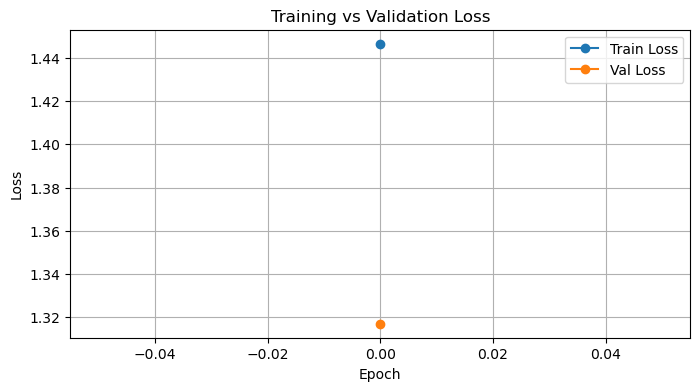

KeyboardInterrupt: 

In [92]:
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# 🔧 設定裝置
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 🔧 初始化模型 & 優化器
# 🔧 初始化模型 & 優化器
cnn_backbone = MultiScaleCNN()  # 這是你定義的多尺度CNN
# 動態計算 cnn_out_dim（從你的 MultiScaleCNN 得到，此處僅示範用 dummy 輸入）
dummy_S = torch.randn(1, 3, 32, 32)
dummy_M = torch.randn(1, 3, 64, 64)
dummy_L = torch.randn(1, 3, 128, 128)
cnn_backbone = MultiScaleCNN()
dummy_out = cnn_backbone(dummy_S, dummy_M, dummy_L)
cnn_out_dim = dummy_out.shape[1]
print("Calculated CNN output dimension:", cnn_out_dim)

gat_out_dim = 256  # CustomGAT 輸出維度，8 heads × 32 = 256
final_out_dim = 35  # 預測 35 維結果

engineered_dim = 14  # 你工程化的特徵維度

fusion_in_dim = cnn_out_dim + engineered_dim
fusion_mlp = FusionMLP(in_dim=fusion_in_dim, dropout_rate=0.5)

# 建立綜合模型 HEVisium
model = HEVisium(cnn_backbone=cnn_backbone, fusion_mlp=fusion_mlp,
                    cnn_out_dim=cnn_out_dim, engineered_dim=engineered_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
loss_fn = torch.nn.MSELoss()  # 或依需求替換其他損失函數

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=10)  # 假設 EarlyStopping 類已實現

# 記錄訓練日誌
log_file = open("training_log.csv", mode="w", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Spearman", "Learning Rate"])

train_losses = []
val_losses = []


# 🔁 開始訓練
num_epochs = 150
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_spearman = evaluate(model, val_loader, loss_fn, device)

    # ✅ 儲存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved best model!")

    # ✅ 調整學習率
    scheduler.step(val_loss)

    # ✅ 寫入 CSV log
    lr = optimizer.param_groups[0]['lr']
    csv_writer.writerow([epoch+1, train_loss, val_loss, val_spearman, lr])

    # ✅ 印 epoch 結果
    print(f"Epoch {epoch+1}/{num_epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | ρ: {val_spearman:.4f} | lr: {lr:.2e}")

    # ✅ 更新 loss list 並畫圖
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    plot_losses(train_losses, val_losses)

    # ✅ Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered.")
        break

# ✅ 關閉 log 檔案
log_file.close()


# Only S

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##############################
# Modified MultiScaleCNN 模型 - 僅接收 S_tile
##############################
class MultiScaleCNN_S(nn.Module):
    def __init__(self):
        super(MultiScaleCNN_S, self).__init__()
        # 只使用 S_branch: Input: [3,32,32] → Output: [16,8,8]
        self.conv_s = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),   # [16,32,32]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),         # [16,16,16]
            nn.Conv2d(16, 16, kernel_size=3, padding=1),   # [16,16,16]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)          # [16,8,8]
        )
    def forward(self, S_tile):
        # 展平： [B,16,8,8] → [B, 16*8*8] = [B, 1024]
        f_s = self.conv_s(S_tile).view(S_tile.size(0), -1)
        return f_s

##########################################
# FusionMLP 模型：將 CNN 輸出與 engineered node features 融合後經 MLP 直接輸出35維
##########################################
class FusionMLP(nn.Module):
    def __init__(self, in_dim, dropout_rate=0.5):
        """
        in_dim: 融合後的輸入維度，= cnn_out_dim + engineered_dim
        dropout_rate: dropout 機率
        """
        super(FusionMLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc_out = nn.Linear(256, 35)
    
    def forward(self, x):
        # x: [B, in_dim]
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc_out(x)
        return x  # 最終輸出 [B, 35]

##########################################
# HEVisium 融合模型：將 CNN 與 engineered 特徵融合後輸出35維結果
##########################################
class HEVisium(nn.Module):
    def __init__(self, cnn_backbone, fusion_mlp, cnn_out_dim=1024, engineered_dim=14):
        """
        cnn_backbone: MultiScaleCNN_S 模型，輸出 cnn_out_dim (1024)
        fusion_mlp: 融合 MLP 模型，輸入維度 = cnn_out_dim + engineered_dim
        engineered_dim: engineered node features 維度，此處為 14
        final_out_dim: 最終預測維度固定為 35（在 fusion_mlp 中固定輸出）
        """
        super(HEVisium, self).__init__()
        self.cnn_backbone = cnn_backbone
        self.fusion_mlp = fusion_mlp
    
    def forward(self, S_tile, node_features):
        # CNN 部分：輸出 [B, cnn_out_dim]
        cnn_feats = self.cnn_backbone(S_tile)
        # 融合 engineered node features：node_features 形狀 [B, engineered_dim]
        combined = torch.cat([cnn_feats, node_features], dim=1)  # [B, cnn_out_dim + engineered_dim]
        out = self.fusion_mlp(combined)  # [B, 35]
        return out

##########################################
# 使用示例
##########################################

In [116]:
import torch
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

# ------------------------------
# 訓練一個 epoch
# ------------------------------
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch in pbar:
        # 取出圖像 patch 與 engineered node features，注意我們不再使用 'adj_list' 與 'edge_feat'
        S_tile = batch['S_tile'].to(device)
        label = batch['label'].to(device)
        node_feat = batch['node_feat'].to(device)  # engineered node features, shape [B, 14]
        
        optimizer.zero_grad()
        
        # 新的模型 forward 僅使用 S_tile, M_tile, L_tile, node_feat
        out = model(S_tile, node_feat)
        
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * S_tile.size(0)
        avg_loss = total_loss / ((pbar.n + 1) * dataloader.batch_size)
        pbar.set_postfix(loss=loss.item(), avg=avg_loss)
    
    return total_loss / len(dataloader.dataset)

# ------------------------------
# 驗證模型
# ------------------------------
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    
    pbar = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in pbar:
            S_tile = batch['S_tile'].to(device)
            label = batch['label'].to(device)
            node_feat = batch['node_feat'].to(device)
            
            # 新的 forward 調用
            out = model(S_tile, node_feat)
            
            loss = loss_fn(out, label)
            total_loss += loss.item() * S_tile.size(0)
            preds.append(out.cpu())
            targets.append(label.cpu())
            
            pbar.set_postfix(loss=loss.item())
    
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    
    # 使用 Spearman 相關係數計算每個輸出維度的相關性
    scores = [spearmanr(preds[:, i], targets[:, i])[0] for i in range(preds.shape[1])]
    spearman_avg = np.nanmean(scores)
    
    return total_loss / len(dataloader.dataset), spearman_avg

# ------------------------------
# 預測函數
# ------------------------------
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_meta = []
    
    with torch.no_grad():
        for batch in dataloader:
            S_tile = batch['S_tile'].to(device)
            node_feat = batch['node_feat'].to(device)
            # meta 信息通常包含 spot 或 slide 識別信息
            meta = batch['meta']  
            
            out = model(S_tile, node_feat)
            all_preds.append(out.cpu())
            all_meta.extend(meta)
    
    return torch.cat(all_preds).numpy(), all_meta


In [117]:
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# 🔧 設定裝置
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 🔧 初始化模型 & 優化器
# 🔧 初始化模型 & 優化器
cnn_out_dim =1024
fusion_in_dim = cnn_out_dim + engineered_dim  # 1024 + 14 = 1038
    
    # 創建模型模組
cnn_model = MultiScaleCNN_S()
fusion_mlp = FusionMLP(in_dim=fusion_in_dim, dropout_rate=0.5)
    
model = HEVisium(cnn_backbone=cnn_model, fusion_mlp=fusion_mlp, 
                     cnn_out_dim=cnn_out_dim, engineered_dim=engineered_dim).to(device)
    

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
loss_fn = torch.nn.MSELoss()  # 或依需求替換其他損失函數

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=10)  # 假設 EarlyStopping 類已實現

# 記錄訓練日誌
log_file = open("training_log.csv", mode="w", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Spearman", "Learning Rate"])

train_losses = []
val_losses = []


# 🔁 開始訓練
num_epochs = 150
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_spearman = evaluate(model, val_loader, loss_fn, device)

    # ✅ 儲存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved best model!")

    # ✅ 調整學習率
    scheduler.step(val_loss)

    # ✅ 寫入 CSV log
    lr = optimizer.param_groups[0]['lr']
    csv_writer.writerow([epoch+1, train_loss, val_loss, val_spearman, lr])

    # ✅ 印 epoch 結果
    print(f"Epoch {epoch+1}/{num_epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | ρ: {val_spearman:.4f} | lr: {lr:.2e}")

    # ✅ 更新 loss list 並畫圖
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    plot_losses(train_losses, val_losses)

    # ✅ Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered.")
        break

# ✅ 關閉 log 檔案
log_file.close()


✅ Using device: mps


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training:   0%|          | 0/209 [00:00<?, ?it/s]/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_30582/3814644018.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'node_feat': torch.tensor(self.node_feats[idx], dtype=torch.float) if self.node_feats is not None else None,


KeyboardInterrupt: 

# CNN_s + MMLP for node + MLP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 假設你已經有以下兩個模塊：
# MultiScaleCNN_S: 僅對 S_tile 進行處理，輸出 [B, cnn_out_dim]（例如 cnn_out_dim = 1024）
# EngineeredFeaturesMLP: 處理 engineered node_features（例如 shape [B, 14]）輸出 [B, emb_dim]（例如 emb_dim = 256）

class MultiScaleCNN_S(nn.Module):
    def __init__(self):
        super(MultiScaleCNN_S, self).__init__()
        self.conv_s = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),   # [16, 16, 16]
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    # [16, 8, 8]
        )
    def forward(self, S_tile):
        # 展平 [B, 16, 8, 8] → [B, 16*8*8] = [B, 1024]
        out = self.conv_s(S_tile).view(S_tile.size(0), -1)
        return out

class EngineeredFeaturesMLP(nn.Module):
    def __init__(self, in_dim=14, dropout_rate=0.5):
        super(EngineeredFeaturesMLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout_rate)
    def forward(self, x):
        # 輸入 x: [B, 14]
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        return x  # 輸出 [B, 256]

# 融合後的 MLP 模型，最終輸出 35 維
class FusionMLP(nn.Module):
    def __init__(self, in_dim, dropout_rate=0.5):
        super(FusionMLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(256, 35)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc_out(x)
        return x

# 綜合模型：先用 CNN 提取圖像特徵，再融合 engineered 特徵，最後通過 MLP 輸出
class HEVisium(nn.Module):
    def __init__(self, cnn_backbone, eng_mlp, fusion_mlp, cnn_out_dim=1024, eng_dim=14):
        """
        cnn_backbone: MultiScaleCNN_S 模型，輸出 cnn_out_dim（例如 1024）
        eng_mlp: EngineeredFeaturesMLP 模型，輸出維度為 256
        fusion_mlp: 融合 MLP 模型，輸入維度 = cnn_out_dim + 256，最終輸出 35 維
        """
        super(HEVisium, self).__init__()
        self.cnn_backbone = cnn_backbone
        self.eng_mlp = eng_mlp
        self.fusion_mlp = fusion_mlp
        
    def forward(self, S_tile, engineered_feats):
        # CNN 分支：處理 S_tile
        cnn_feats = self.cnn_backbone(S_tile)  # [B, cnn_out_dim] (這裡是 1024)
        # engineered 特徵分支：處理 engineered_feats（比如原本的 14 維）
        eng_feats = self.eng_mlp(engineered_feats)  # [B, 256]
        # 融合：拼接 cnn_feats 和 eng_feats
        combined = torch.cat([cnn_feats, eng_feats], dim=1)  # [B, 1024+256 = 1280]
        out = self.fusion_mlp(combined)  # 輸出 [B, 35]
        return out
    
    import torch
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

# ------------------------------
# 訓練一個 epoch
# ------------------------------
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch in pbar:
        # 取出圖像 patch 與 engineered node features，注意我們不再使用 'adj_list' 與 'edge_feat'
        S_tile = batch['S_tile'].to(device)
        label = batch['label'].to(device)
        node_feat = batch['node_feat'].to(device)  # engineered node features, shape [B, 14]
        
        optimizer.zero_grad()
        
        # 新的模型 forward 僅使用 S_tile, M_tile, L_tile, node_feat
        out = model(S_tile, node_feat)
        
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * S_tile.size(0)
        avg_loss = total_loss / ((pbar.n + 1) * dataloader.batch_size)
        pbar.set_postfix(loss=loss.item(), avg=avg_loss)
    
    return total_loss / len(dataloader.dataset)

# ------------------------------
# 驗證模型
# ------------------------------
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    
    pbar = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in pbar:
            S_tile = batch['S_tile'].to(device)
            label = batch['label'].to(device)
            node_feat = batch['node_feat'].to(device)
            
            # 新的 forward 調用
            out = model(S_tile, node_feat)
            
            loss = loss_fn(out, label)
            total_loss += loss.item() * S_tile.size(0)
            preds.append(out.cpu())
            targets.append(label.cpu())
            
            pbar.set_postfix(loss=loss.item())
    
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    
    # 使用 Spearman 相關係數計算每個輸出維度的相關性
    scores = [spearmanr(preds[:, i], targets[:, i])[0] for i in range(preds.shape[1])]
    spearman_avg = np.nanmean(scores)
    
    return total_loss / len(dataloader.dataset), spearman_avg

# ------------------------------
# 預測函數
# ------------------------------
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_meta = []
    
    with torch.no_grad():
        for batch in dataloader:
            S_tile = batch['S_tile'].to(device)
            node_feat = batch['node_feat'].to(device)
            # meta 信息通常包含 spot 或 slide 識別信息
            meta = batch['meta']  
            
            out = model(S_tile, node_feat)
            all_preds.append(out.cpu())
            all_meta.extend(meta)
    
    return torch.cat(all_preds).numpy(), all_meta



In [ ]:
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# 🔧 設定裝置
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 🔧 初始化模型 & 優化器
# 🔧 初始化模型 & 優化器
cnn_out_dim = 1024
    # Engineered 特徵 MLP 輸出固定為 256
eng_out_dim = 256  
fusion_in_dim = cnn_out_dim + eng_out_dim  # 1024 + 256 = 1280
    
    
    # 創建模型模組
cnn_model = MultiScaleCNN_S()
fusion_mlp = FusionMLP(in_dim=fusion_in_dim, dropout_rate=0.5)

eng_mlp = EngineeredFeaturesMLP(in_dim=14, dropout_rate=0.5)

model = HEVisium(cnn_backbone=cnn_model, eng_mlp=eng_mlp, fusion_mlp=fusion_mlp,
                     cnn_out_dim=cnn_out_dim, eng_dim=14).to(device)
    

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
loss_fn = torch.nn.MSELoss()  # 或依需求替換其他損失函數

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=10)  # 假設 EarlyStopping 類已實現

# 記錄訓練日誌
log_file = open("training_log.csv", mode="w", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Spearman", "Learning Rate"])

train_losses = []
val_losses = []


# 🔁 開始訓練
num_epochs = 150
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_spearman = evaluate(model, val_loader, loss_fn, device)

    # ✅ 儲存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved best model!")

    # ✅ 調整學習率
    scheduler.step(val_loss)

    # ✅ 寫入 CSV log
    lr = optimizer.param_groups[0]['lr']
    csv_writer.writerow([epoch+1, train_loss, val_loss, val_spearman, lr])

    # ✅ 印 epoch 結果
    print(f"Epoch {epoch+1}/{num_epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | ρ: {val_spearman:.4f} | lr: {lr:.2e}")

    # ✅ 更新 loss list 並畫圖
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    plot_losses(train_losses, val_losses)

    # ✅ Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered.")
        break

# ✅ 關閉 log 檔案
log_file.close()


# Only node features

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NodeFeatureMLP(nn.Module):
    def __init__(self, input_dim, final_out_dim, dropout_rate=0.5):
        """
        input_dim: 輸入的 engineered node features 維度 (例如 14)
        final_out_dim: 最終預測輸出的維度 (例如 35)
        dropout_rate: Dropout 機率
        """
        super(NodeFeatureMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        # 輸出層：最終輸出 final_out_dim 維的結果 (例如35)
        self.fc_out = nn.Linear(1024, final_out_dim)
    
    def forward(self, x):
        # x: [B, input_dim]
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        out = self.fc_out(x)
        return out  # [B, final_out_dim]

def build_model(input_dim, final_out_dim, dropout_rate=0.5, learning_rate=0.0001, weight_decay=0.001):
    """
    input_dim: 輸入的 engineered node features 維度（例如 14）
    final_out_dim: 最終預測輸出的維度（例如 35）
    dropout_rate: Dropout 機率
    learning_rate: 優化器學習率
    weight_decay: Adam 優化器中的 weight_decay，用於 L2 正則化
    """
    model = NodeFeatureMLP(input_dim, final_out_dim, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()  # 或其他你需要的損失函數
    return model, optimizer, loss_fn

# -------------------------------
# 使用示例：
# 假設我們的 engineered node features 的 shape 為 [B, 14],
# 且最終我們要預測 35 維結果
# -------------------------------
if __name__ == "__main__":
    B = 32  # 批次大小
    input_dim = 14
    final_out_dim = 35
    
    # 模擬輸入數據: engineered node features
    node_features = torch.randn(B, input_dim)
    
    model, optimizer, loss_fn = build_model(input_dim, final_out_dim, dropout_rate=0.5, learning_rate=0.0001, weight_decay=0.001)
    
    # 模擬模型前向傳播
    output = model(node_features)
    print("Output shape:", output.shape)  # 預期: [32, 35]


Output shape: torch.Size([32, 35])


In [119]:
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

# ------------------------------
# 訓練一個 epoch
# ------------------------------
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch in pbar:
        # 取出圖像 patch 與 engineered node features，注意我們不再使用 'adj_list' 與 'edge_feat'
        label = batch['label'].to(device)
        node_feat = batch['node_feat'].to(device)  # engineered node features, shape [B, 14]
        out = model( node_feat)

        optimizer.zero_grad()
        
        # 新的模型 forward 僅使用 S_tile, M_tile, L_tile, node_feat
        
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * S_tile.size(0)
        avg_loss = total_loss / ((pbar.n + 1) * dataloader.batch_size)
        pbar.set_postfix(loss=loss.item(), avg=avg_loss)
    
    return total_loss / len(dataloader.dataset)

# ------------------------------
# 驗證模型
# ------------------------------
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    
    pbar = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in pbar:
            label = batch['label'].to(device)
            node_feat = batch['node_feat'].to(device)
            
            # 新的 forward 調用
            out = model( node_feat)
            
            loss = loss_fn(out, label)
            total_loss += loss.item() * S_tile.size(0)
            preds.append(out.cpu())
            targets.append(label.cpu())
            
            pbar.set_postfix(loss=loss.item())
    
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    
    # 使用 Spearman 相關係數計算每個輸出維度的相關性
    scores = [spearmanr(preds[:, i], targets[:, i])[0] for i in range(preds.shape[1])]
    spearman_avg = np.nanmean(scores)
    
    return total_loss / len(dataloader.dataset), spearman_avg

# ------------------------------
# 預測函數
# ------------------------------
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_meta = []
    
    with torch.no_grad():
        for batch in dataloader:
            node_feat = batch['node_feat'].to(device)
            # meta 信息通常包含 spot 或 slide 識別信息
            meta = batch['meta']  
            out = model( node_feat)
            all_preds.append(out.cpu())
            all_meta.extend(meta)
    
    return torch.cat(all_preds).numpy(), all_meta



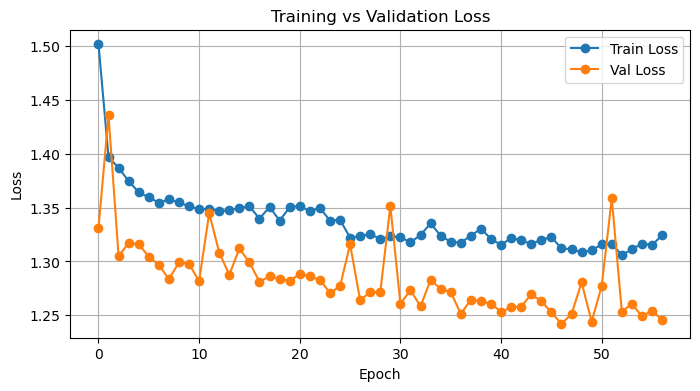

EarlyStopping counter: 10/10
⛔ Early stopping triggered.


In [121]:
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# 🔧 設定裝置
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")


input_dim = 14
final_out_dim = 35
    

    
model, optimizer, loss_fn = build_model(input_dim, final_out_dim, dropout_rate=0.5, learning_rate=0.0001, weight_decay=0.001)
    
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
loss_fn = torch.nn.MSELoss()  # 或依需求替換其他損失函數

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=10)  # 假設 EarlyStopping 類已實現

# 記錄訓練日誌
log_file = open("training_log.csv", mode="w", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Spearman", "Learning Rate"])

train_losses = []
val_losses = []


# 🔁 開始訓練
num_epochs = 150
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_spearman = evaluate(model, val_loader, loss_fn, device)

    # ✅ 儲存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved best model!")

    # ✅ 調整學習率
    scheduler.step(val_loss)

    # ✅ 寫入 CSV log
    lr = optimizer.param_groups[0]['lr']
    csv_writer.writerow([epoch+1, train_loss, val_loss, val_spearman, lr])

    # ✅ 印 epoch 結果
    print(f"Epoch {epoch+1}/{num_epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | ρ: {val_spearman:.4f} | lr: {lr:.2e}")

    # ✅ 更新 loss list 並畫圖
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    plot_losses(train_losses, val_losses)

    # ✅ Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered.")
        break

# ✅ 關閉 log 檔案
log_file.close()


# Prediction

In [122]:
# ===== 需要的 Libraries =====
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import csv


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")


model.load_state_dict(torch.load("best_model.pt"))
model.eval()


✅ Using device: mps


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_30582/2115051499.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model

NodeFeatureMLP(
  (fc1): Linear(in_features=14, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=1024, out_features=35, bias=True)
)

In [123]:
# 正確方式

test_data = torch.load("../SML_test_dataset.pt")
import torch
from torch.utils.data import Subset
import numpy as np


# 載入資料
graph_data = torch.load("../test_graph_dataset.pt")
# ====== Step 2: 建立 Dataset ======
test_dataset = importDataset(
    S_tiles=test_data['S_tiles'],
    M_tiles=test_data['M_tiles'],
    L_tiles=test_data['L_tiles'],
    labels=test_data['labels'],
    meta_info=test_data['meta_info'],
    normal_coords=test_data['normal_coords'],
    node_feats=graph_data['node_feats'],
    adj_lists=graph_data['adj_lists'],
    edge_feats=graph_data['edge_feats']
)



test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_30582/1390325486.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("../SML_test_dataset.p

In [125]:
test_preds, test_meta = predict(model, test_loader, device)


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_30582/3814644018.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'node_feat': torch.tensor(self.node_feats[idx], dtype=torch.float) if self.node_feats is not None else None,


In [64]:
test_preds.shape

(2088, 35)

In [126]:
import h5py

# ==== 讀取 test spot index 用於對應 ID ====
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example: S_7


ensemble_df = pd.DataFrame(test_preds, columns=[f"C{i+1}" for i in range(test_preds.shape[1])])
ensemble_df.insert(0, 'ID', test_spot_table.index)
ensemble_df.to_csv("submission＿only_nodes.csv", index=False)
print("✅ Saved submission.csv")


✅ Saved submission.csv
